In [11]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import analysis_utils as utils
from scipy.optimize import curve_fit

from itertools import groupby

import importlib
import h5py

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py'>

In [3]:
c = 299792458    # m / s
SI2ev = (1 / 1.6e-19) * c

m = 2000 * (83.5e-9)**3 * 4 * np.pi / 3
hbar = 6.626e-34
kb = 1.380649e-23

In [4]:
c_mv = 5.522e-08
amp2kev = 6278.541436077518

## DM data

In [5]:
window_length = 5000  # 10 ms analysis window, assume dt=2 us
bins = np.arange(0, 5, 0.01)
bc = 0.5 * (bins[:-1] + bins[1:])

In [6]:
bc = None
hhs, good_dets, temps, charge_level = [], [], [], []
for i in range(1440):
    f = h5py.File(f'/Users/yuhan/work/nanospheres/data/dm_data_processed/20241025_10e_long/20241025_def_10e_{i}_processed.hdf5', 'r')
    
    if bc is None:
        bc = f['data_processed'].attrs['bin_center_kev']
    
    charge_level.append(f['data_processed'].attrs['charge_level'])
    hhs.append(f['data_processed']['histogram'][:])
    good_dets.append(f['data_processed']['good_detection'][:])
    temps.append(f['data_processed']['temp'][:])

    f.close()

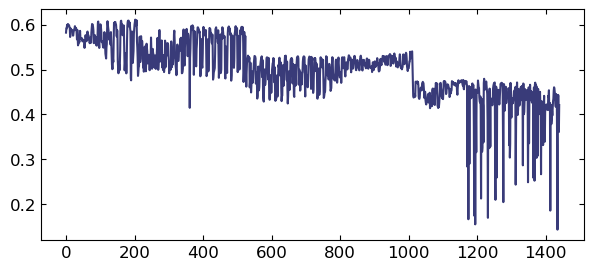

In [7]:
plt.plot(charge_level)

In [8]:
temps = np.asarray(temps)
hhs = np.asarray(hhs)
good_dets = np.array(good_dets)

q1, q2, q3 = np.quantile(temps.flatten(), [0.25, 0.5, 0.75])
temp_thr = q2 + 1.5 * (q3 - q1)

hh_cold = hhs[temps < temp_thr]
hh_cold_and_good = hhs[np.logical_and(temps < temp_thr, good_dets)]

Text(0, 0.5, 'Count')

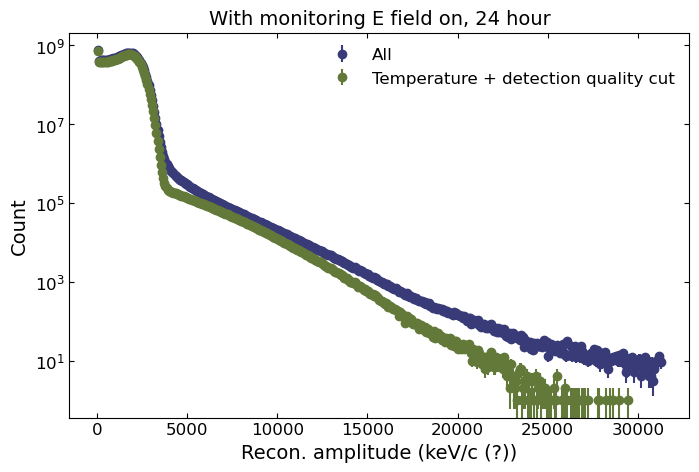

In [9]:
hh_all_sum = np.sum(np.sum(hhs, axis=0), axis=0)
hh_cold_sum = np.sum(hh_cold, axis=0)
hh_cold_and_good_sum = np.sum(hh_cold_and_good, axis=0)

plt.subplots(figsize=(8, 5))
plt.errorbar(bc, hh_all_sum, np.sqrt(hh_all_sum), fmt='o', label='All')
# plt.errorbar(bc, hh_cold_sum, np.sqrt(hh_cold_sum), fmt='o')
plt.errorbar(bc, hh_cold_and_good_sum, np.sqrt(hh_cold_and_good_sum), fmt='o', label='Temperature + detection quality cut')

plt.yscale('log')
# plt.xlim(0, 50)

plt.title('With monitoring E field on, 24 hour')
plt.legend(frameon=False)
plt.xlabel('Recon. amplitude (keV/c (?))')
plt.ylabel('Count')

#### 10 min of data without electric drive

In [90]:
bc = None
hhs, good_dets, temps, charge_level = [], [], [], []
for i in range(10):
    f = h5py.File(f'/Users/yuhan/work/nanospheres/data/dm_data_processed/20241029_8e_10m/20241029_d_8e_{i+1}_processed.hdf5', 'r')
    
    if bc is None:
        bc = f['data_processed'].attrs['bin_center_kev']
    
    hhs.append(f['data_processed']['histogram'][:])
    good_dets.append(f['data_processed']['good_detection'][:])
    temps.append(f['data_processed']['temp'][:])

    f.close()

In [130]:
temps = np.asarray(temps)
hhs = np.asarray(hhs)
good_dets = np.array(good_dets)

q1, q2, q3 = np.quantile(temps.flatten(), [0.25, 0.5, 0.75])
temp_thr = q2 + 1.5 * (q3 - q1)

hh_cold = hhs[temps < temp_thr]
hh_cold_and_good = hhs[np.logical_and(temps < temp_thr, good_dets)]

Text(0, 0.5, 'Count')

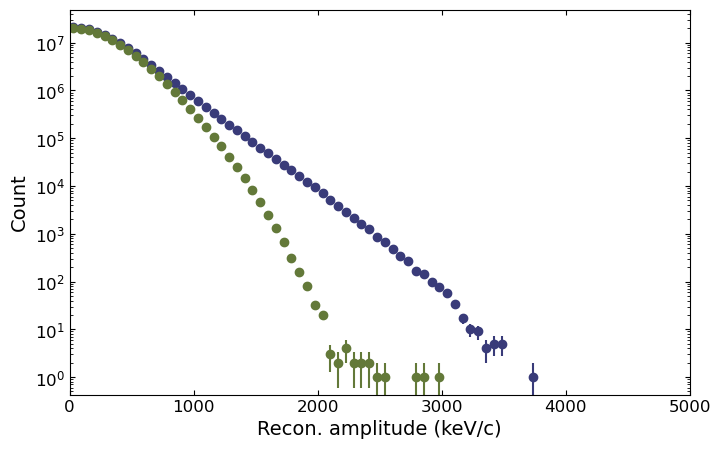

In [131]:
hh_all_sum = np.sum(np.sum(hhs, axis=0), axis=0)
hh_cold_sum = np.sum(hh_cold, axis=0)
hh_cold_and_good_sum = np.sum(hh_cold_and_good, axis=0)

plt.subplots(figsize=(8, 5))
plt.errorbar(bc, hh_all_sum, np.sqrt(hh_all_sum), fmt='o')
# plt.errorbar(bc, hh_cold_sum, np.sqrt(hh_cold_sum), fmt='o')
plt.errorbar(bc, hh_cold_and_good_sum, np.sqrt(hh_cold_and_good_sum), fmt='o')

plt.yscale('log')
plt.xlim(0, 5000)

plt.xlabel('Recon. amplitude (keV/c)')
plt.ylabel('Count')

In [128]:
cold_and_good_events_idx = []
threshold = 2000

for i, hh_file in enumerate(hhs):
    for j, hh in enumerate(hh_file):
        if np.sum(hh[bc > threshold]) > 0:
            if temps[i, j] < temp_thr:
                if good_dets[i, j]:
                    cold_and_good_events_idx.append(np.array([i, j]))

In [129]:
len(cold_and_good_events_idx)

35

In [159]:
window_length_long = 5000
def plot_hist_events(data_files, file_idx, idx):
    file = data_files[file_idx]
    f = h5py.File(file, "r")
    
    zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3
    
    dtt = f['data'].attrs['delta_t']
    fs = int(np.ceil(1 / dtt))

    zz_bp = utils.bandpass_filtered(zz, fs, 30000, 100000)

    # Long window    
    zz_long = np.reshape(zz, (int(zz.size / window_length_long), window_length_long))
    zz_bp_long = np.reshape(zz_bp, (int(zz_bp.size / window_length_long), window_length_long))
    
    idx_window = np.full(zz.size, True)
    idx_window[0:window_length_long*idx] = False
    idx_window[window_length_long*(idx+1):] = False

    amp, amp_lp, temp = utils.recon_force(dtt, zz_bp_long[idx], c_mv)
    hh = np.histogram(amp_lp[500:-500], bins=bins)[0]
    
    fig, ax = plt.subplots(1, 3, figsize=(9, 2))
    ax[0].errorbar(bc, hh, np.sqrt(hh), fmt='o', markersize=2)
    ax[0].set_yscale('log')
    ax[0].set_xlim(0, 5000)
#     ax[0].set_ylim(1, 5e4)
    ax[0].set_xlabel('Reconstructed amp. (keV/c)', fontsize=12)
    ax[0].set_ylabel('Count', fontsize=12)

    ax[1].plot(dtt*1e6*np.arange(0, amp_lp[80:-50].size), amp_lp[80:-50]*amp2kev/1000, color='grey')
#     ax[1].set_ylim(-5, 5)
    ax[1].set_xlabel('Time ($\mu s$)', fontsize=12)
    ax[1].set_ylabel('Amp. (a. u.)', fontsize=12)
    
    ax[2].plot(dtt*1e6*np.arange(0, zz_bp_long[idx].size), zz_bp_long[idx])
#     ax[2].twinx().plot(dtt*1e6*np.arange(0, zz_bp_long[idx].size), ee[idx_window], 'lightgrey')
    ax[2].set_ylabel('Z homodyne (V)', fontsize=12)
    ax[2].set_xlabel('Time ($\mu s$)', fontsize=12)
    
    fig.suptitle(f'Event (file_{file_idx}, window_{idx})')
    fig.tight_layout()
    
    f.close()
    return amp_lp, hh, zz_bp_long[idx], fig, ax

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2175/618271531.py:34: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel('Time ($\mu s$)', fontsize=12)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2175/618271531.py:40: SyntaxWarning: invalid escape sequence '\m'
  ax[2].set_xlabel('Time ($\mu s$)', fontsize=12)


/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2175/618271531.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3, figsize=(9, 2))


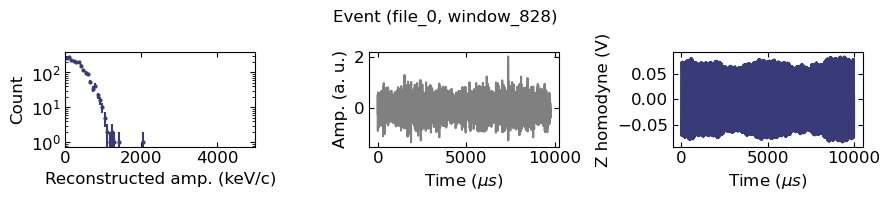

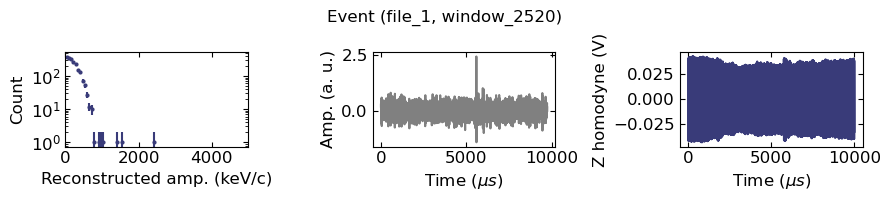

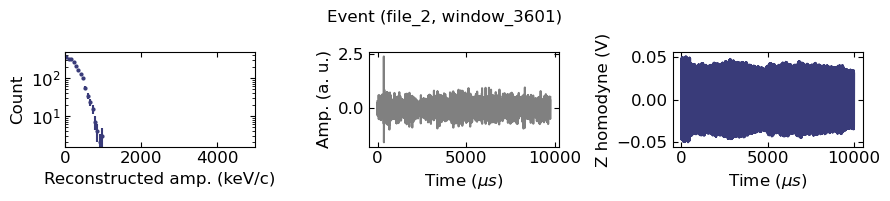

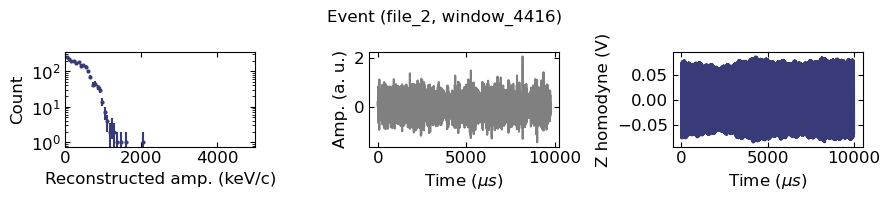

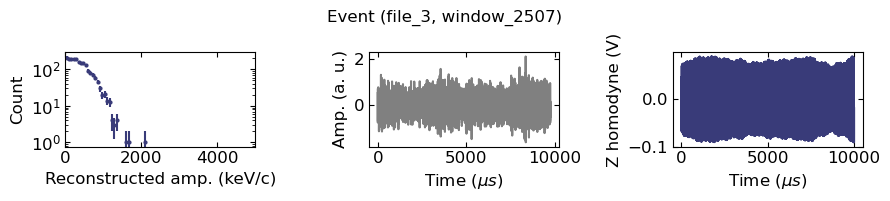

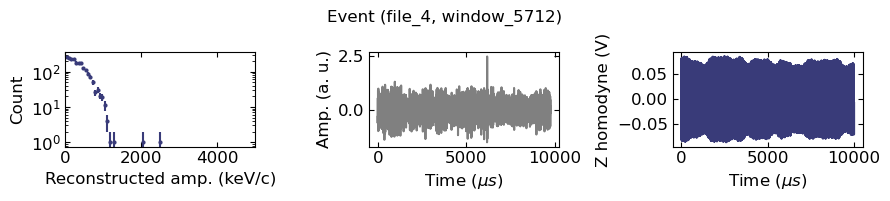

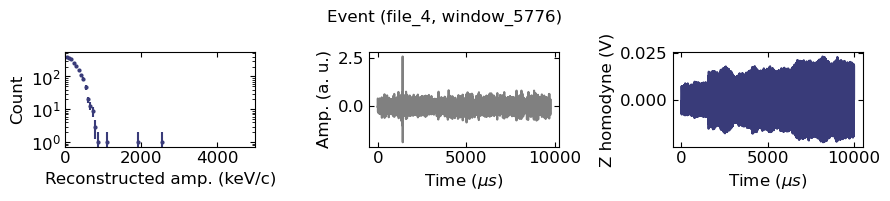

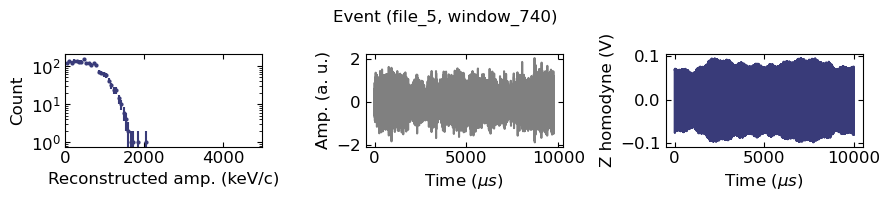

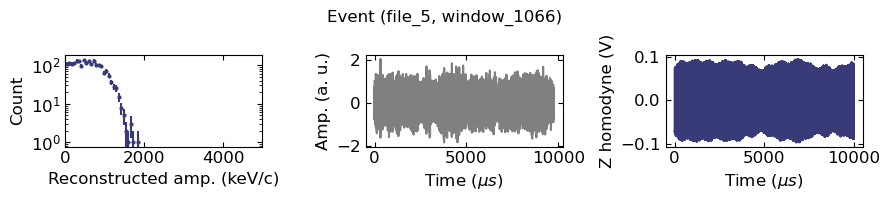

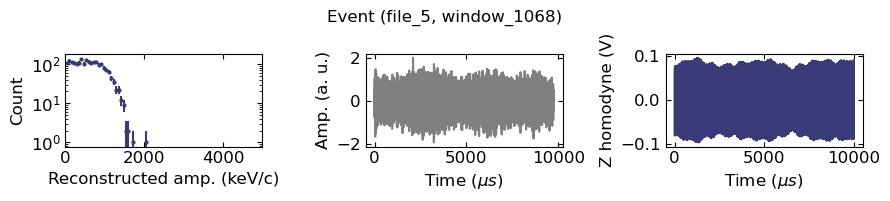

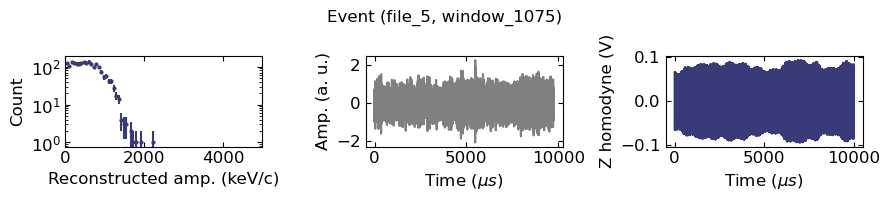

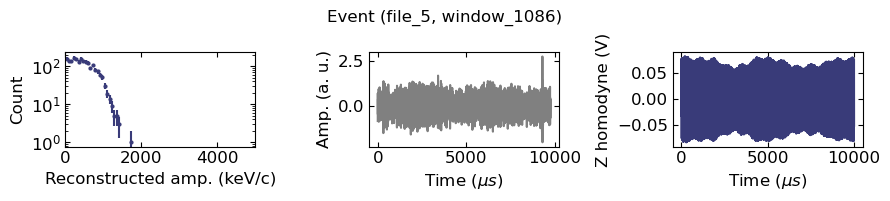

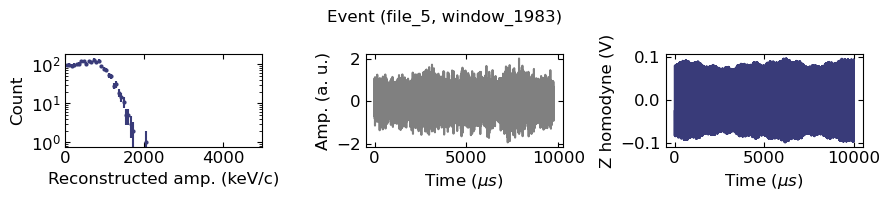

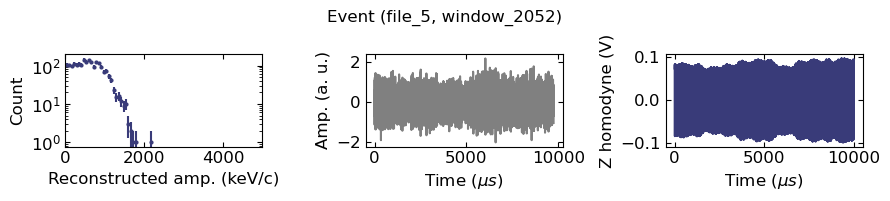

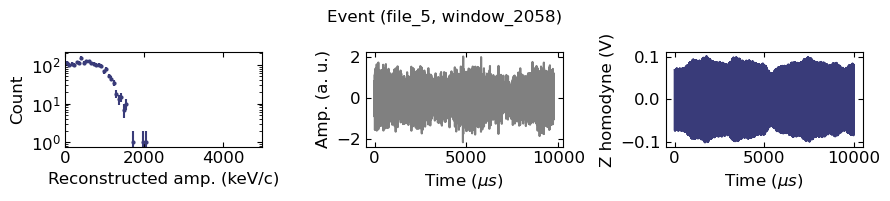

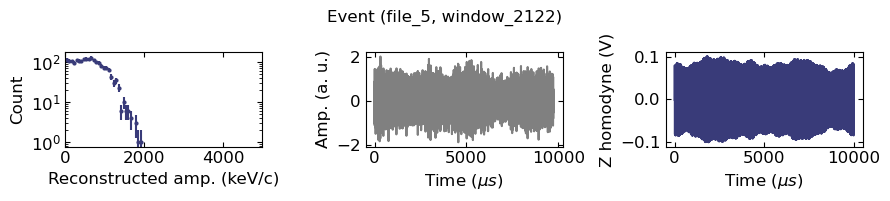

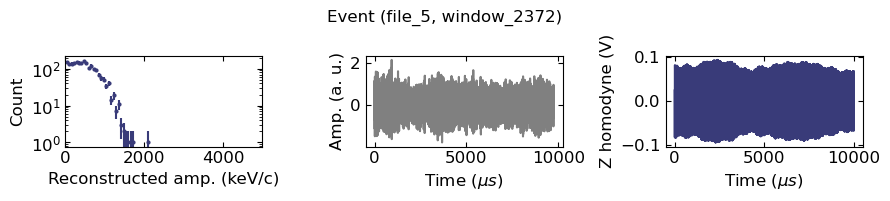

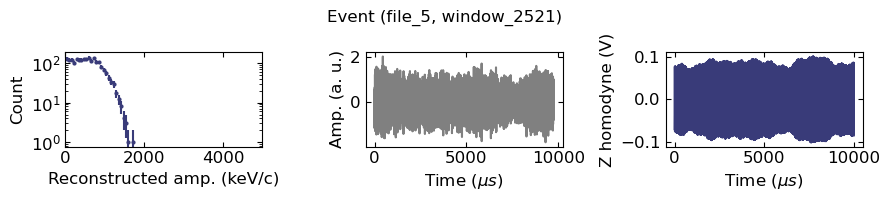

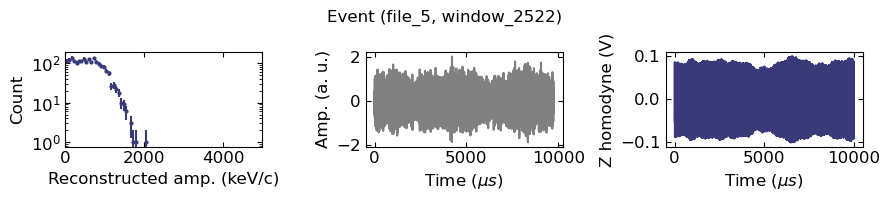

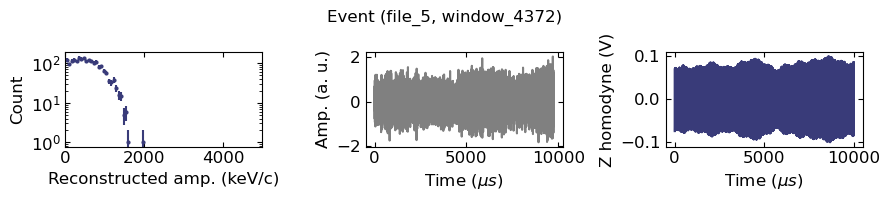

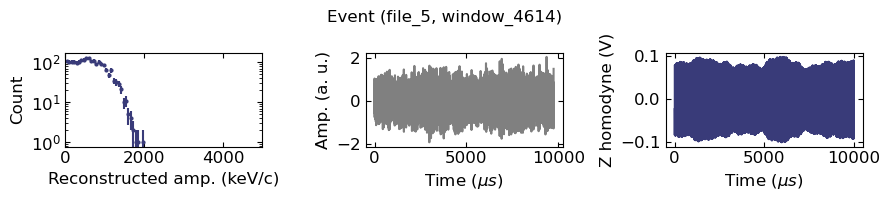

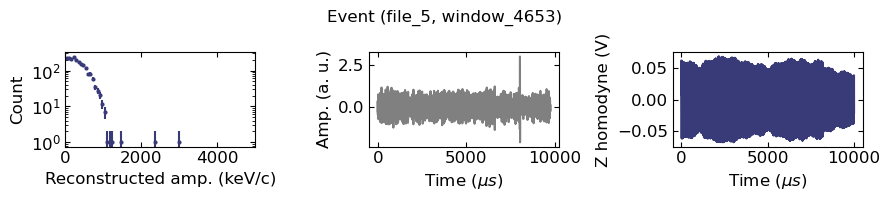

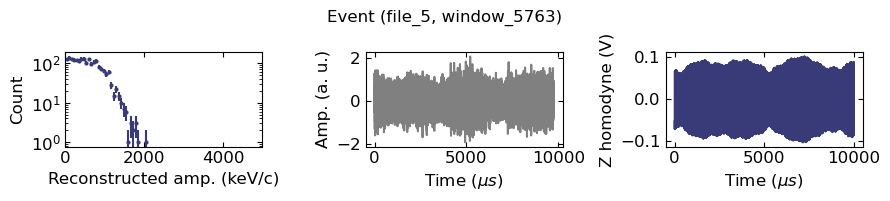

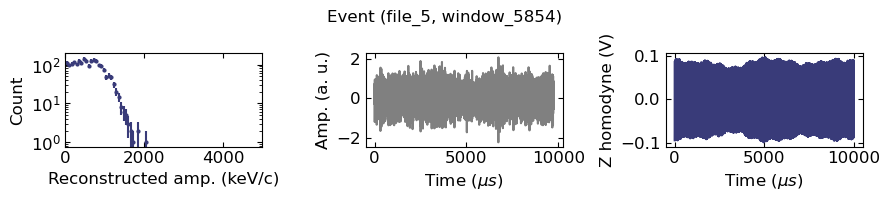

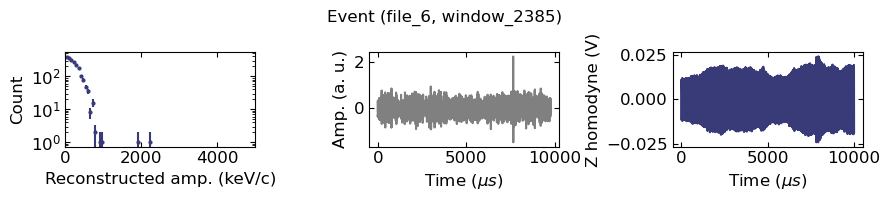

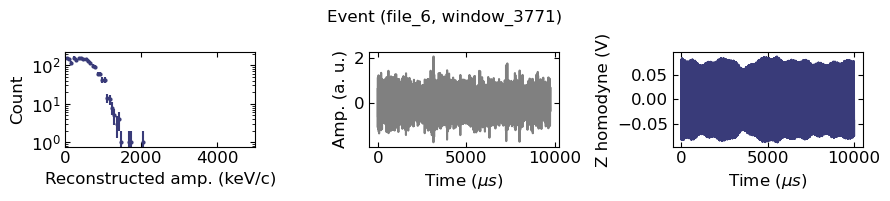

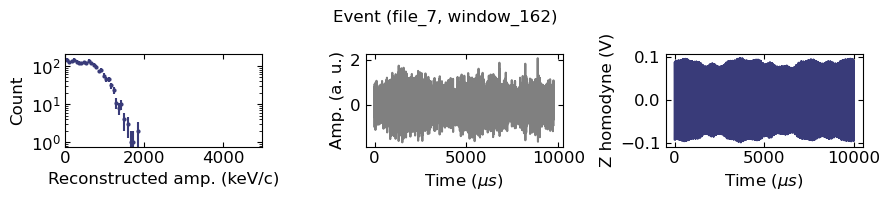

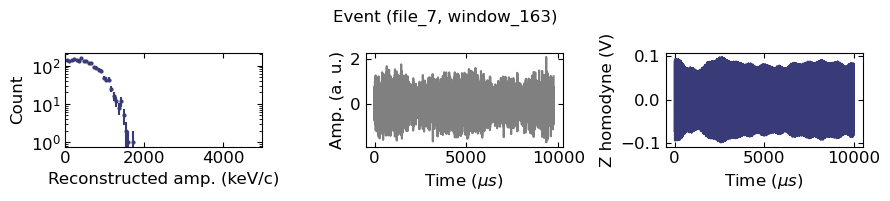

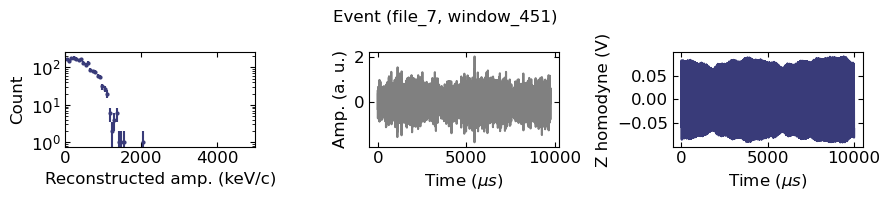

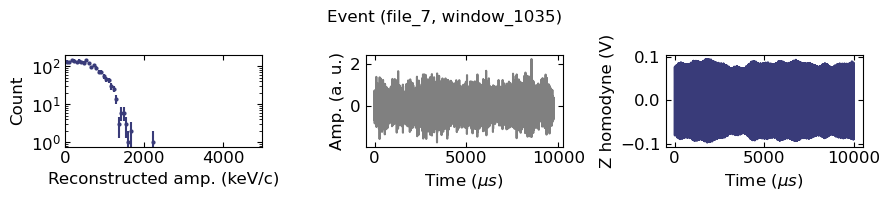

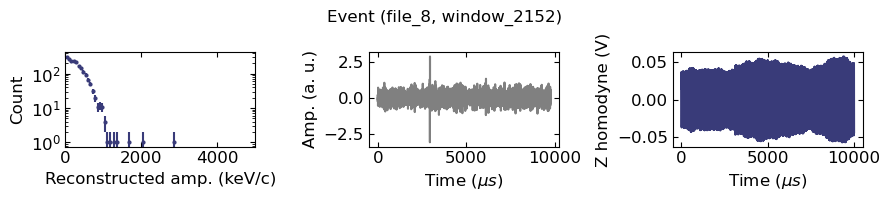

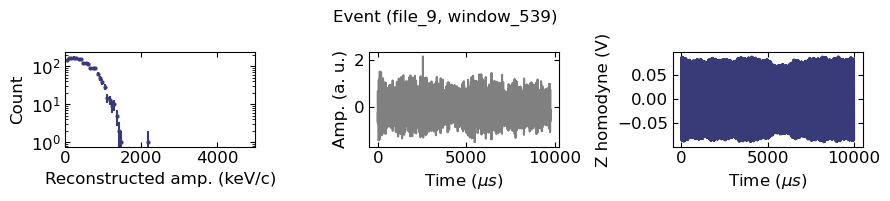

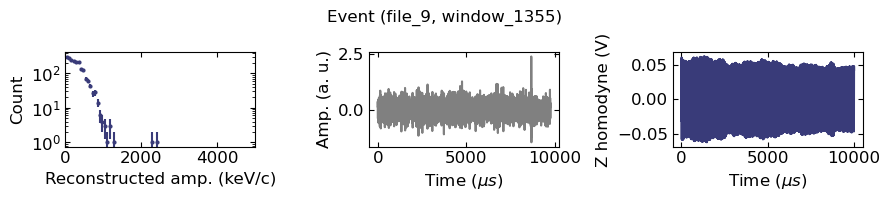

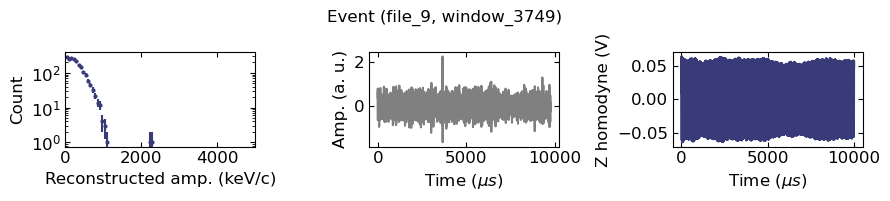

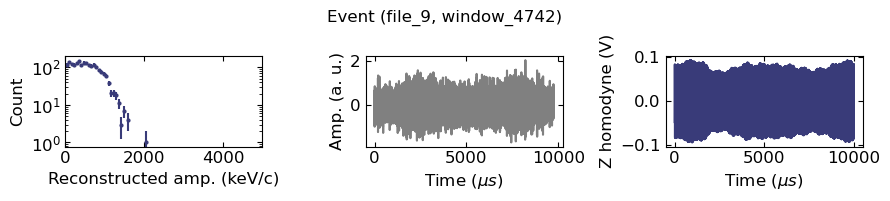

In [160]:
data_dir = r'/Volumes/LaCie/dm_data/20241029_8e_10m'
combined_path = os.path.join(data_dir, '*.hdf5')
data_files = glob.glob(combined_path)

for i, j in cold_and_good_events_idx[:]:
    _, _, _, _, _ = plot_hist_events(data_files, i, j)

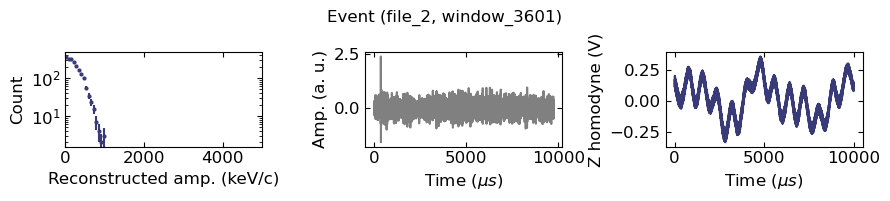

In [157]:
i, j = 2, 3601
amp_lp, _, _, _, _ = plot_hist_events(data_files, i, j)

(200.0, 300.0)

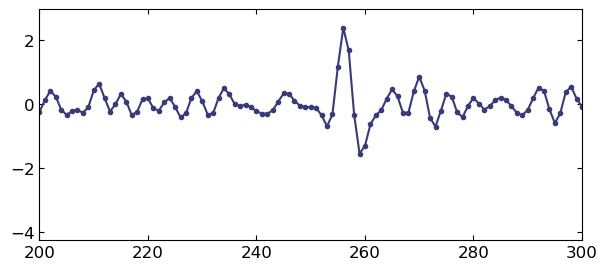

In [158]:
plt.plot(amp_lp*amp2kev/1000, '.-')
# plt.ylim(-2, 2)
plt.xlim(200, 300)

## Calibration factor for the new sphere

In [7]:
folder = r'/Users/yuhan/work/nanospheres/data/electric_calibration/20241024_electric_calibration_10e'
dataset = r''
combined_path = os.path.join(folder, dataset, '*_89khz_*.hdf5')
data_files = sorted(glob.glob(combined_path))

In [9]:
vp2p = [0.5, 1, 1.5, 2]
order = [0, 2, 1, 3]
data_files_ordered_89khz = [data_files[i] for i in order]

In [14]:
c_mv_89khz = utils.get_c_mv(data_files_ordered_89khz, vp2p, 89000 * 2 * np.pi, passband=(88700, 89300), charge=10, n_chunk=5)
means_89khz = np.mean(np.asarray(c_mv_89khz), axis=1)
errors_89khz = np.sqrt(np.var(np.asarray(c_mv_89khz), axis=1) / (5-1))

The averaged calibration factor $C_{mV}$ = 5.522e-08


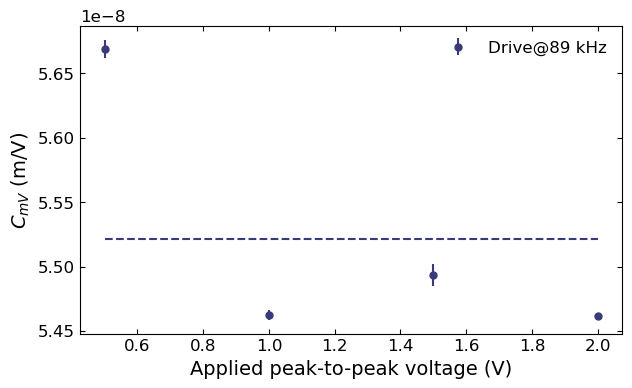

In [15]:
colors = plt.colormaps.get_cmap('tab20b').resampled(6).colors
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.errorbar(vp2p, means_89khz, yerr=errors_89khz, fmt='.', markersize=10, label='Drive@89 kHz')
ax.hlines(np.mean(means_89khz), vp2p[0], vp2p[-1], linestyle='--', color=colors[0])

ax.set_xlabel('Applied peak-to-peak voltage (V)')
ax.set_ylabel('$C_{mV}$ (m/V)')

# ax.set_ylim(9.3e-8, 1e-7)
ax.legend(frameon=False)

c_mv = np.mean(means_89khz)
print(fr'The averaged calibration factor $C_{{mV}}$ = {c_mv:.3e}')

In [12]:
file = r'/Volumes/LaCie/electric_calibration/20241024_electric_calibration_10e/20241024_de_10e_noefield_0.hdf5'
dtt, nn = utils.load_timestreams(file, ['D'])

zz = nn[0]

Text(50, 5e-28, 'Imprecision noise floor: 6.02e-27 m$^2$/Hz')

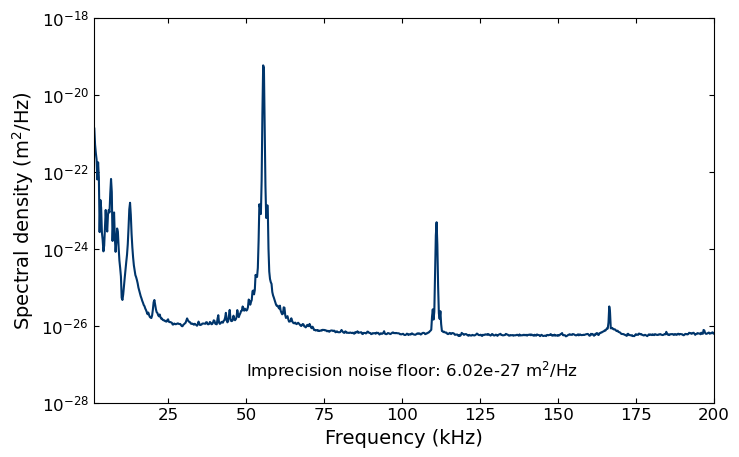

In [19]:
ccal = 1 / (c_mv**2)
ffz, ppz = utils.get_psd(dt=dtt, zz=zz, nperseg=2**11)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(ffz/1000, ppz/ccal, '-',color=yale_colors[0])
# ax.plot(ffz/1000, np.exp(utils.log_lorentzian_with_const(ffz*2*np.pi, *popt)), 'k', label='Fit')

ax.set_yscale('log')
ax.set_ylim(1e-28, 1e-18)
ax.set_xlim(1, 200)

ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Spectral density (m$^2$/Hz)')

all_idx = np.logical_and(ffz>175000, ffz<200000)
noise_floor = np.mean(ppz[all_idx]/ccal)
ax.text(50, 0.5e-27, f'Imprecision noise floor: {noise_floor:.2e} m$^2$/Hz', fontsize=12)
# ax.text(50, 1.75e-28, f'$\eta_{{z}}$ $\simeq$ {2.13e-27 / noise_floor:.2f} (?)', fontsize=12)

## Pulse calibration

Process impulse calibration data. The resolution is somewhat worse than before, possibly due to pulses being 100 ms apart.

In [50]:
folder = r'/Users/yuhan/work/nanospheres/data/pulse_calibration/20241025_10e'
datasets = ['20241025_dg_10e_1v', '20241025_dg_10e_3v', '20241025_dg_10e_5v', '20241025_dg_10e_7v', '20241025_dg_10e_9v']
pulseamps = [118, 389, 641, 919, 1175]

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241025_dg_10e_1v
20241025_dg_10e_3v
20241025_dg_10e_5v
20241025_dg_10e_7v
20241025_dg_10e_9v


In [51]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
# Take the average of 700 and 900 kev cases
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]

(0.0, 2000.0)

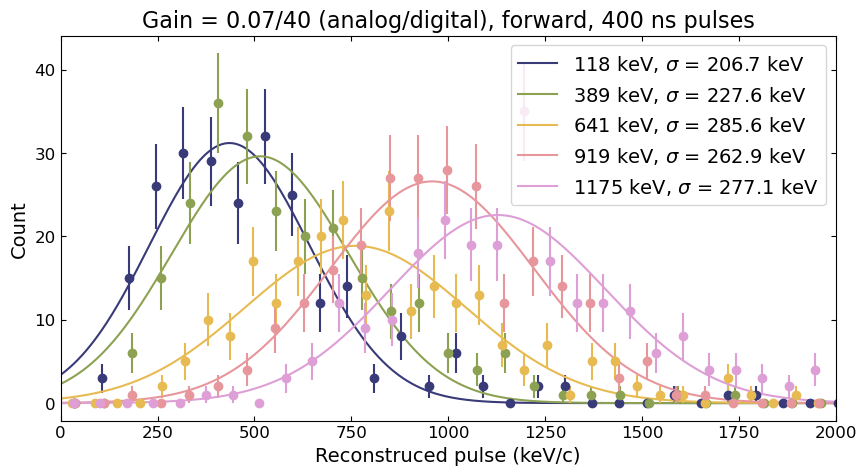

In [53]:
fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.07/40 (analog/digital), forward, 400 ns pulses')
ax.set_xlim(0, 2000)

In [55]:
unnormalized_amps_noise = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, True)

20241025_dg_10e_1v
20241025_dg_10e_3v
20241025_dg_10e_5v
20241025_dg_10e_7v
20241025_dg_10e_9v


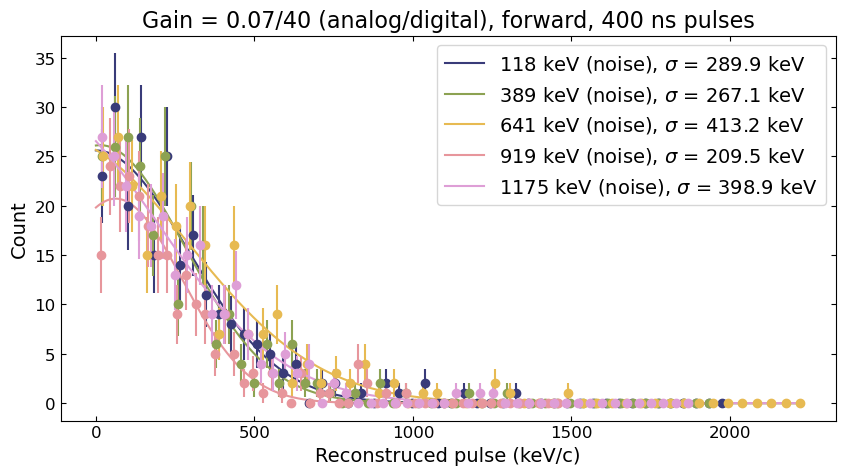

In [56]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus(unnormalized_amps_noise, True)
normalized_amps_noise = [amp * amp2kev for amp in unnormalized_amps_noise]

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps_noise, hhs_noise, bcs_noise, gps_noise, amp2kev=amp2kev, noise=True, title='Gain = 0.07/40 (analog/digital), forward, 400 ns pulses')


In [63]:
print(f'Amplitude to keV converstion factor: {amp2kev}')

Amplitude to keV converstion factor: 6278.541436077518
